In [43]:
#Coefficient of multiple correlation
# The phenotypic characteristics of each stomata complex is extracted by the Mask RCNN and CellProifler pipeline
# !pip install pycytominer
import pandas as pd
import pycytominer
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
morph = pd.read_csv("./Oscar_scaled_avgSCO.csv")

morph.head()

,Unnamed: 0,Metadata_week.x,Metadata_genotype.x,Group,Subgroup,GCO_stomata_desity,GCO_AreaShape_Area,GCO_AreaShape_BoundingBoxArea,GCO_AreaShape_Compactness,GCO_AreaShape_ConvexArea,...,avg_sco_Perimeter,avg_sco_BoundingBoxArea,avg_sco_ConvexArea,avg_sco_Eccentricity,avg_sco_FormFactor,avg_sco_MeanRadius,avg_sco_MaximumRadius,avg_sco_Area,avg_sco_MinorAxisLength,Ratio_G_S_area
0,0,Week1,B73,SS,SS-B73,10,405,576,2.308191,458,...,97.012193,780,478,0.860685,0.558128,3.030867,7.810250,418,18.190126,0.484450
1,1,Week1,B73,SS,SS-B73,10,381,495,2.239848,432,...,86.597980,648,420,0.824073,0.660223,3.238071,8.544004,394,18.064705,0.483503
2,2,Week1,B73,SS,SS-B73,10,490,954,2.565985,605,...,101.254834,840,483,0.912109,0.507433,2.895797,7.280110,414,16.092025,0.591787
3,3,Week1,B73,SS,SS-B73,10,416,750,2.586656,512,...,86.870058,494,363,0.944008,0.559511,2.731353,6.324555,336,12.390288,0.619048
4,4,Week1,B73,SS,SS-B73,10,410,624,2.315030,475,...,85.597980,612,383,0.875284,0.595131,2.913475,7.211103,347,15.644407,0.590778


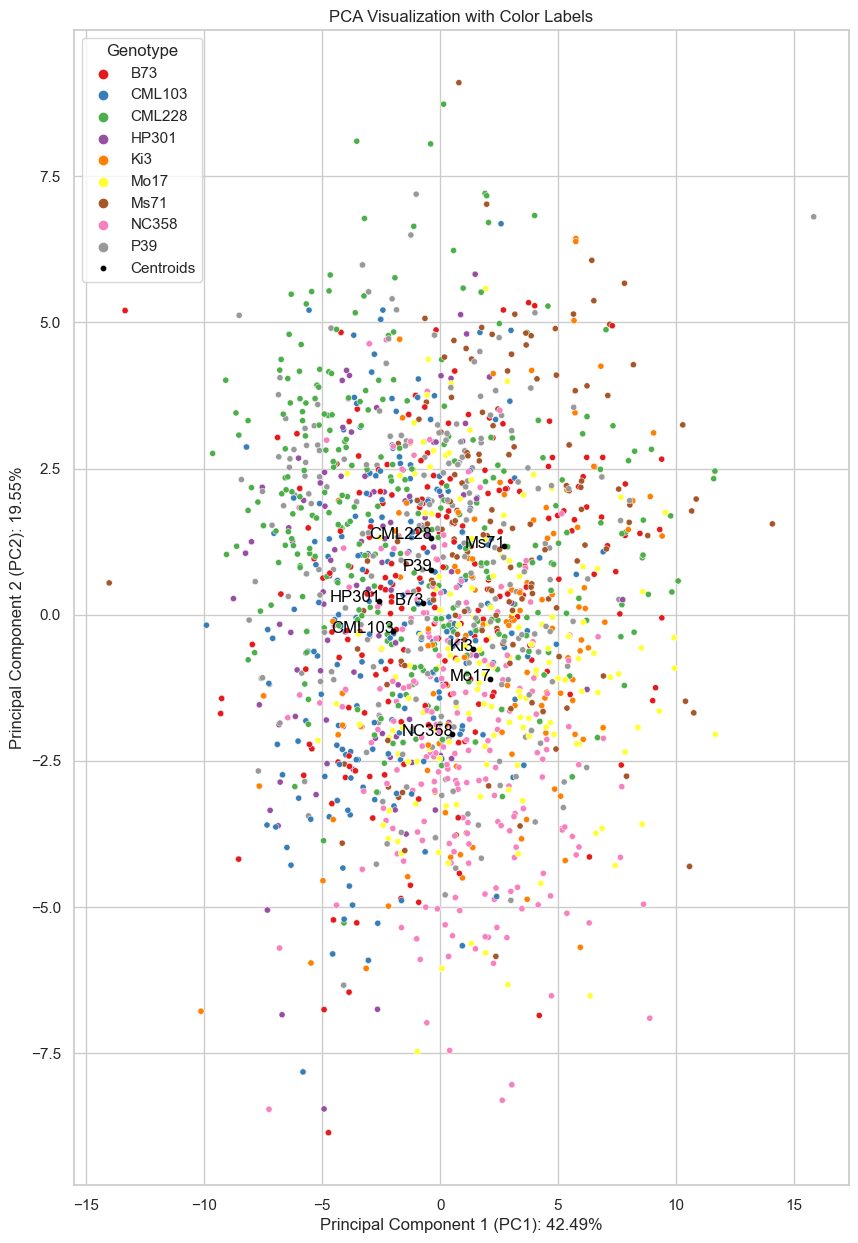

In [44]:
# Redo the PCA base on average parameters of SCO1 and SCO2, lable by genotype

df = morph.copy()
df = df.drop(columns = ['Unnamed: 0', "GCO_stomata_desity"])

# Select numeric columns for normalization
df = df.dropna()

numeric_columns = df.select_dtypes(include='number')

# Create a StandardScaler, Z score normalization
scaler = StandardScaler()


# Fit and transform the selected numeric columns
normalized_data = scaler.fit_transform(numeric_columns)

# Replace the original numeric columns with the normalized values

df[numeric_columns.columns] = normalized_data


import re
df["Metadata_week.x"] = df["Metadata_week.x"].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'Week(\d+)', str(x)) else x)




df.to_csv("Oscar_scaled_morph2.csv", index=False)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(normalized_data)

# Create a DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Concatenate the PCA DataFrame with non-numeric columns
final_df = pd.concat([df.drop(columns=numeric_columns.columns), pca_df], axis=1)


# Calculate centroids of each genotype
centroids = final_df.groupby('Metadata_genotype.x')[['PC1', 'PC2']].mean()

# Plotting PCA results with color labels based on 'Metadata_genotype.x'
sns.set(style="whitegrid")
plt.figure(figsize=(10, 15))

sns.scatterplot(x='PC1', y='PC2', hue='Metadata_genotype.x', data=final_df, palette='Set1', s=20)

# Plot centroids with bigger dots
plt.scatter(centroids['PC1'], centroids['PC2'], color='black', marker='o', s=10, label='Centroids')

# Annotate centroids
for idx, centroid in centroids.iterrows():
    # Adjust the position of labels slightly to avoid overlap with circles
    plt.text(centroid['PC1'] + 0.05, centroid['PC2'] + 0.05, idx, fontsize=12, color='black', ha='right', va='center')

plt.title('PCA Visualization with Color Labels')
plt.xlabel(f'Principal Component 1 (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 (PC2): {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.legend(title='Genotype')

plt.show()


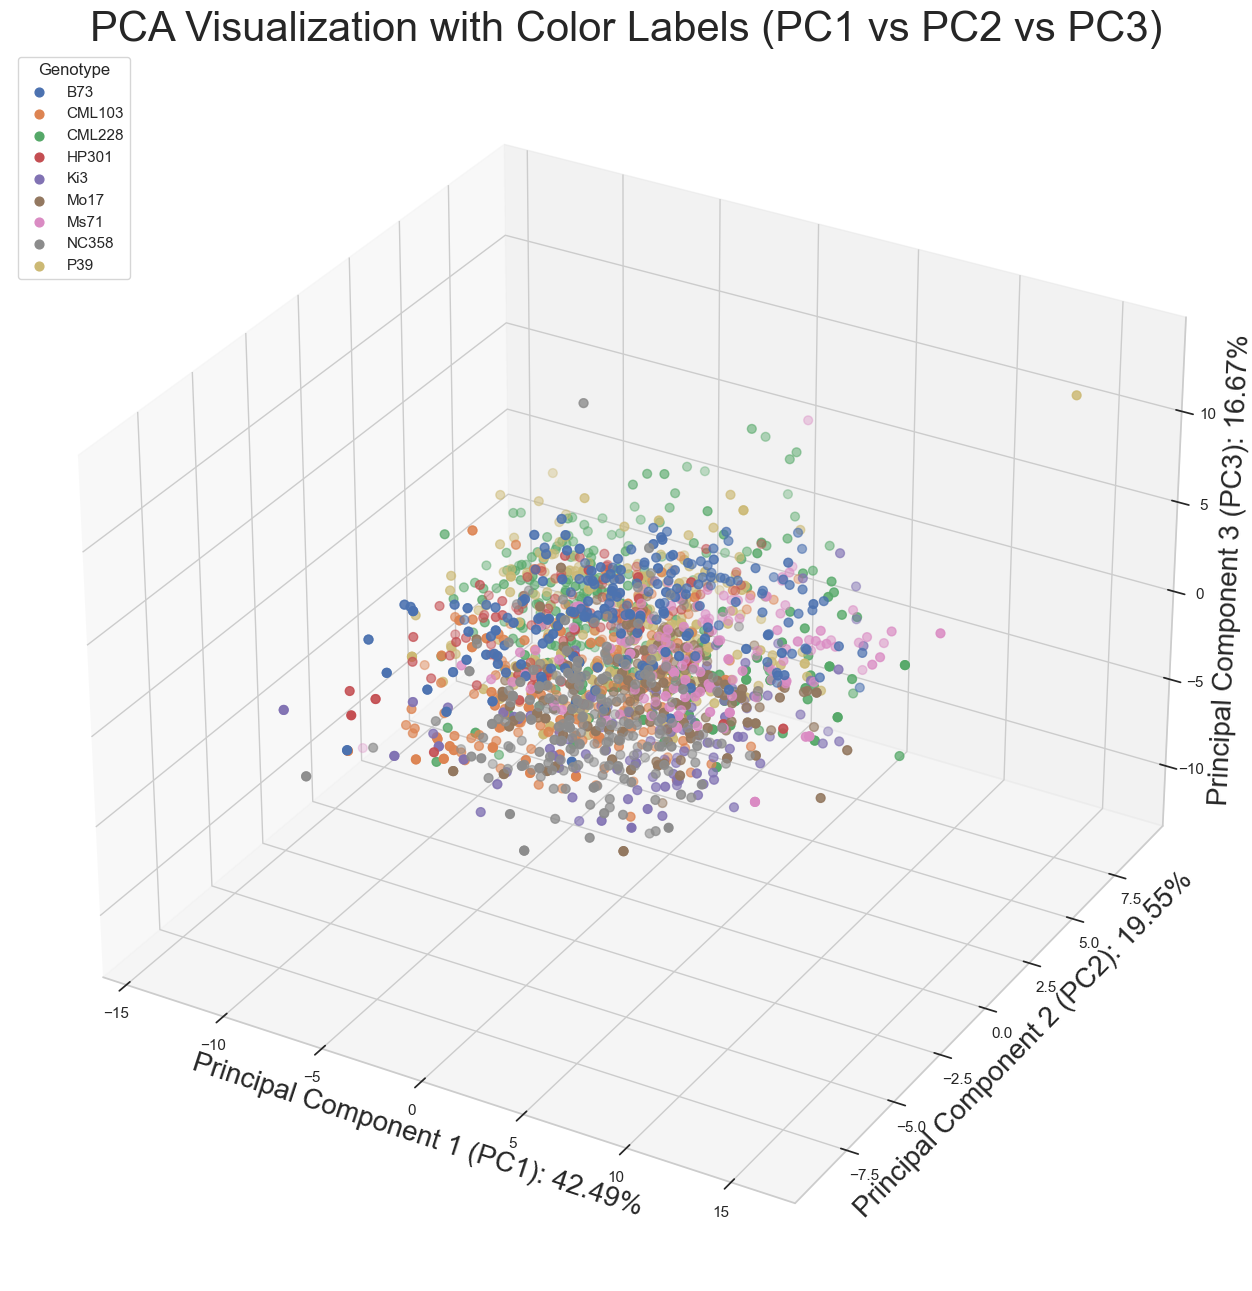

In [45]:

from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting

# Plotting PCA results in 3D with color labels based on 'Metadata_genotype.x'
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for PC1, PC2, and PC3
for Genotype in final_df['Metadata_genotype.x'].unique():
    data = final_df[final_df['Metadata_genotype.x'] == Genotype]
    ax.scatter(data['PC1'], data['PC2'], data['PC3'], label=Genotype, s=40)


ax.set_title('PCA Visualization with Color Labels (PC1 vs PC2 vs PC3)', fontsize=30)
ax.set_xlabel(f'Principal Component 1 (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%', fontsize=20)
ax.set_ylabel(f'Principal Component 2 (PC2): {pca.explained_variance_ratio_[1]*100:.2f}%', fontsize=20)
ax.set_zlabel(f'Principal Component 3 (PC3): {pca.explained_variance_ratio_[2]*100:.2f}%', fontsize=20)
ax.legend(title='Genotype', loc='upper left')
plt.show()



In [47]:
### Train Random forest classifier, In general, Random Forest is not sensitive to the scale of the features
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
df = morph.copy()
df = df.drop(columns = ['Unnamed: 0', "GCO_stomata_desity"])
X = df.filter(regex='^(GCO|avg_)')
y = df.filter(['Metadata_genotype.x'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

# Initialize the RandomForestClassifier, random_state: 
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=None)
rf_classifier.fit(X, y_encoded )
importances = rf_classifier.feature_importances_
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
feature_names = X.columns[sorted_indices]


/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


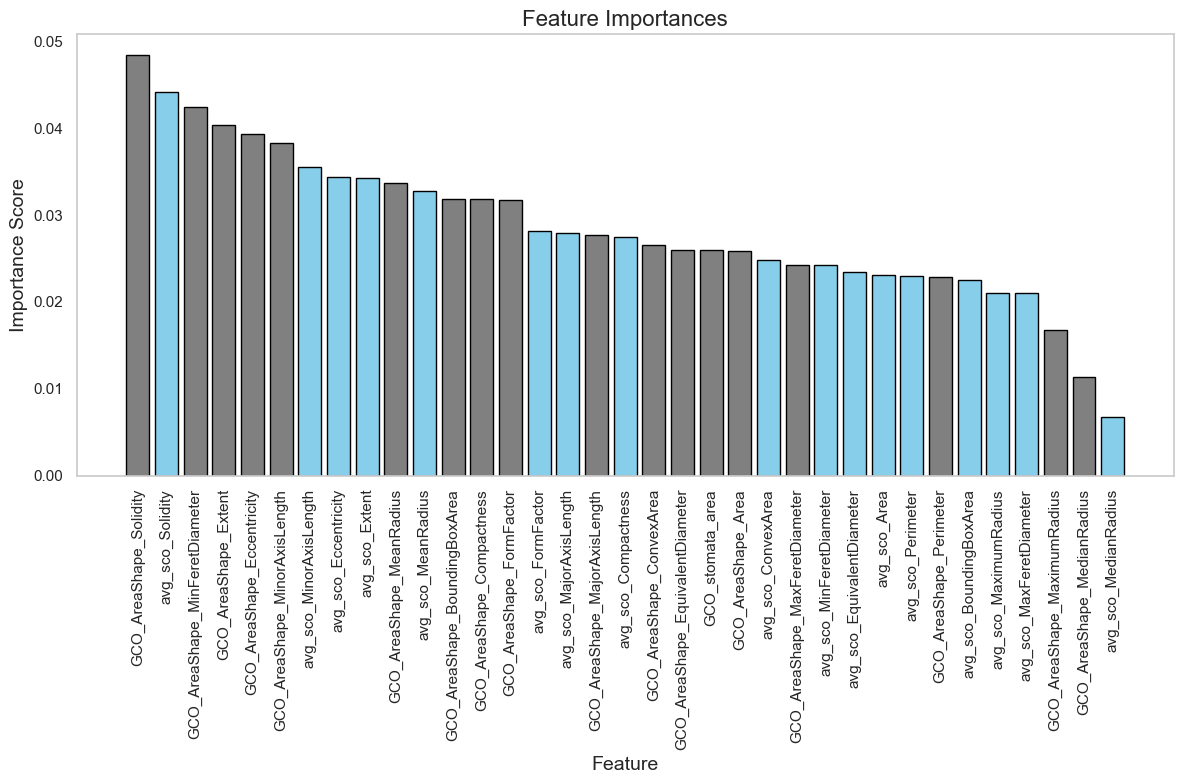

In [48]:
# Create a bar plot of feature importances

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
# Define colors for SCO and GCO features
colors = ['skyblue' if 'avg' in name else 'gray' for name in feature_names]

plt.bar(range(X.shape[1]), sorted_importances, color=colors, edgecolor='black')
plt.grid(False)
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.tight_layout()
plt.show()



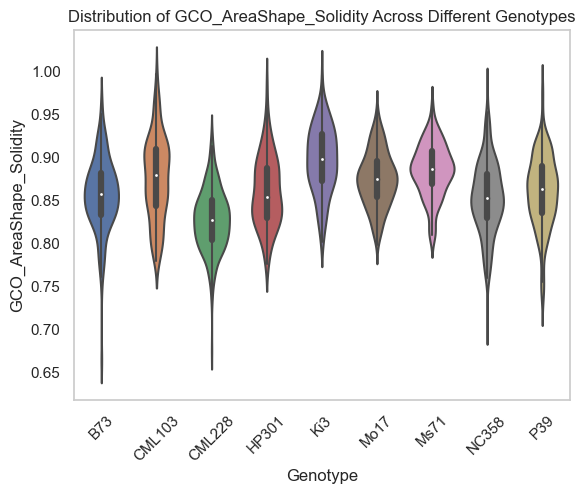

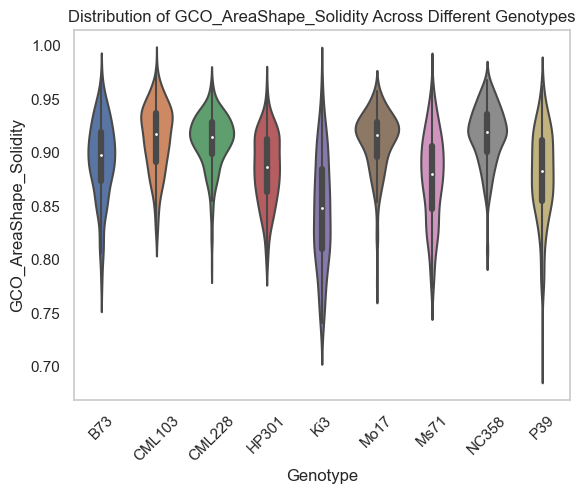

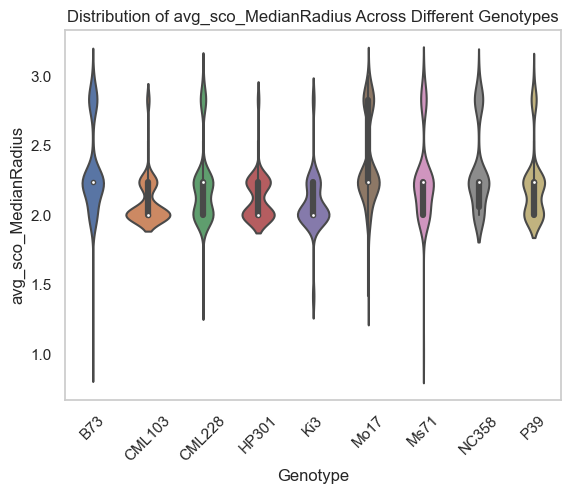

In [54]:
# Visulize the first and the last features

sns.violinplot(x='Metadata_genotype.x', y='GCO_AreaShape_Solidity', data=df)
plt.grid(False)
plt.title('Distribution of GCO_AreaShape_Solidity Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel('GCO_AreaShape_Solidity')
plt.xticks(rotation=45)
plt.show()


sns.violinplot(x='Metadata_genotype.x', y='avg_sco_Solidity', data=df)
plt.grid(False)
plt.title('Distribution of GCO_AreaShape_Solidity Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel('GCO_AreaShape_Solidity')
plt.xticks(rotation=45)
plt.show()

sns.violinplot(x='Metadata_genotype.x', y='avg_sco_MedianRadius', data=df)
plt.grid(False)
plt.title('Distribution of avg_sco_MedianRadius Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel("avg_sco_MedianRadius")
plt.xticks(rotation=45)
plt.show()

In [32]:
# Evaluate Model Performance on all feture

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier with a fixed random_state
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

# Fit the classifier to your data
rf_classifier.fit(X_train, y_train)

# Predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluating the classifier, Accuracy= Total number of predictions/Number of correct predictions
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precision: 0.6973770628850912
Recall: 0.6883408071748879
F1 Score: 0.685684335463663
Accuracy: 0.6883408071748879


In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Assuming y_true are the true labels and y_pred are the predicted labels by your Random Forest classifier
y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels by your Random Forest classifier

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute class-wise precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print results
print("Confusion Matrix:")
print(cm)

print("\nClass-wise Metrics:")
for i in range(len(precision)):
    print(f"Genotype {i}: Precision={precision[i]}, Recall={recall[i]}, F1 Score={f1[i]}")

print("\nOverall Accuracy:", accuracy)

# Get the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Original Label -> Encoded Label:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label} -> {encoded_label}")


Confusion Matrix:
[[54  0  3  2  0  3  1  1  3]
 [ 0 35  7  1  1  0  0  0  0]
 [ 6  6 50  0  0  1  3  2  3]
 [ 5  5  3  9  0  0  0  0  5]
 [ 0  4  1  0 18  0  2  4  0]
 [ 0  0  5  0  0 34  2  5  5]
 [ 2  1  1  0  1  1 25  2  3]
 [ 0 10  5  0  0  1  0 41  1]
 [ 5  3  3  2  1  6  2  0 41]]

Class-wise Metrics:
Genotype 0: Precision=0.75, Recall=0.8059701492537313, F1 Score=0.776978417266187
Genotype 1: Precision=0.546875, Recall=0.7954545454545454, F1 Score=0.6481481481481481
Genotype 2: Precision=0.6410256410256411, Recall=0.704225352112676, F1 Score=0.6711409395973156
Genotype 3: Precision=0.6428571428571429, Recall=0.3333333333333333, F1 Score=0.43902439024390244
Genotype 4: Precision=0.8571428571428571, Recall=0.6206896551724138, F1 Score=0.7200000000000001
Genotype 5: Precision=0.7391304347826086, Recall=0.6666666666666666, F1 Score=0.7010309278350515
Genotype 6: Precision=0.7142857142857143, Recall=0.6944444444444444, F1 Score=0.7042253521126761
Genotype 7: Precision=0.745454545454

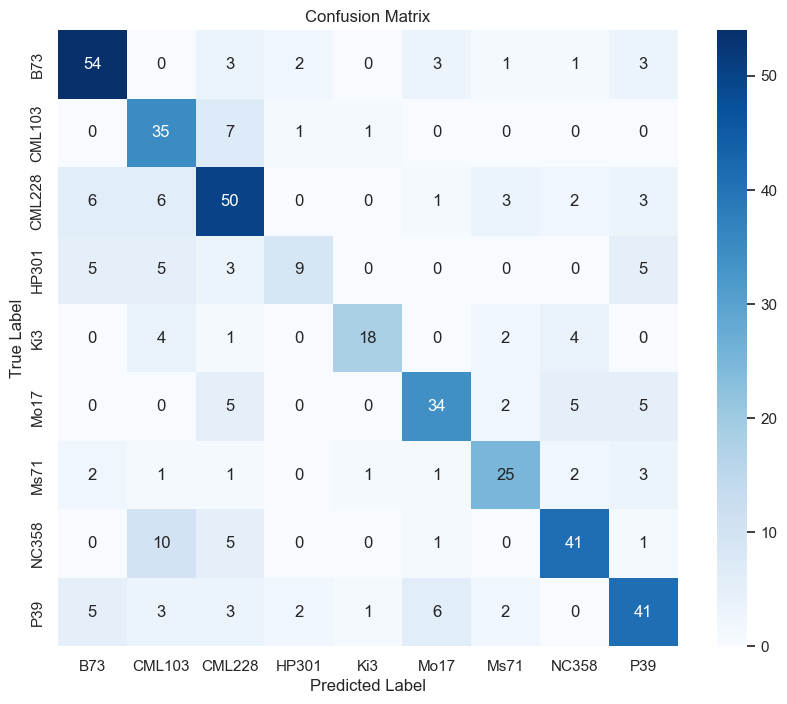

In [34]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
genotypes = df['Metadata_genotype.x'].unique()

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genotypes, yticklabels=genotypes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

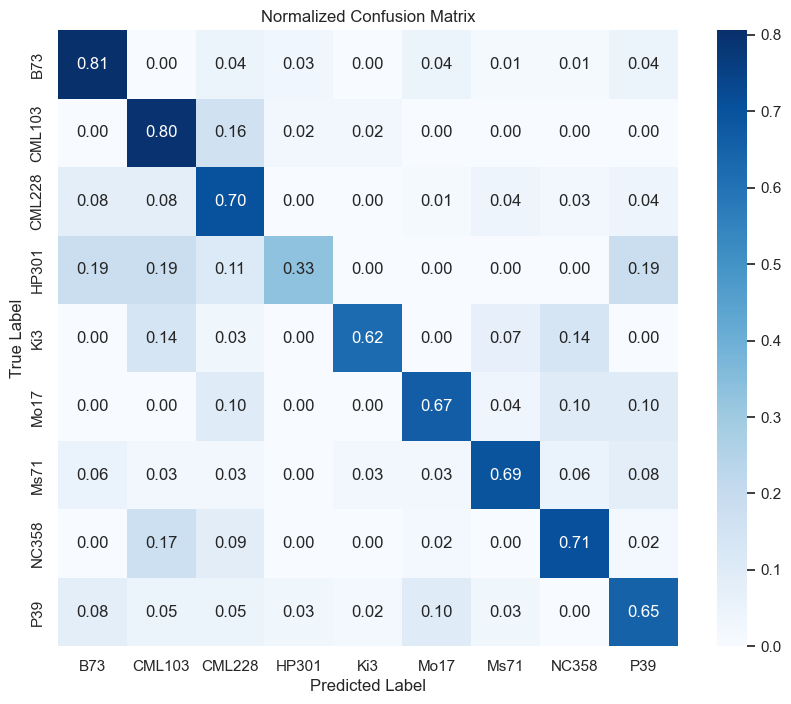

In [35]:
# Normalize the confusion matrix to show proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=genotypes, yticklabels=genotypes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

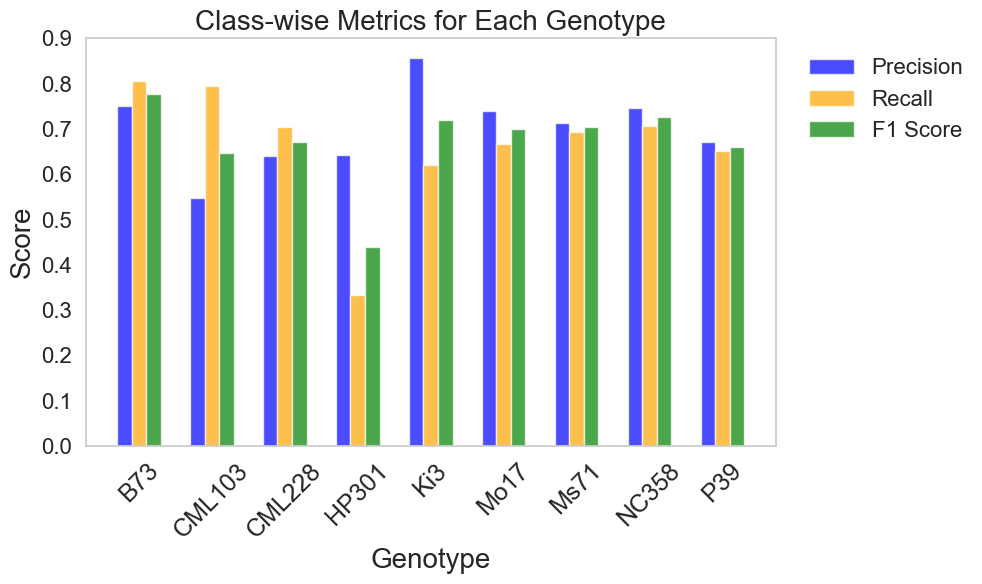

In [184]:

y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels by your Random Forest classifier

# Compute class-wise precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Define the number of genotypes and metrics
num_genotypes = len(genotypes)
num_metrics = 4

# Set the positions for the bars
bar_width = 0.2
index = np.arange(num_genotypes)

# Plotting
plt.figure(figsize=(10, 6), facecolor='none')
plt.grid(False)

plt.bar(index - bar_width, precision, label='Precision', color='blue', width=bar_width, alpha=0.7)
plt.bar(index, recall, label='Recall', color='orange', width=bar_width, alpha=0.7)
plt.bar(index + bar_width, f1_score, label='F1 Score', color='green', width=bar_width, alpha=0.7)

plt.title('Class-wise Metrics for Each Genotype', fontsize=20)
plt.xlabel('Genotype', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(index, genotypes, rotation=45, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.legend(fontsize=16, loc='upper left',  bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()


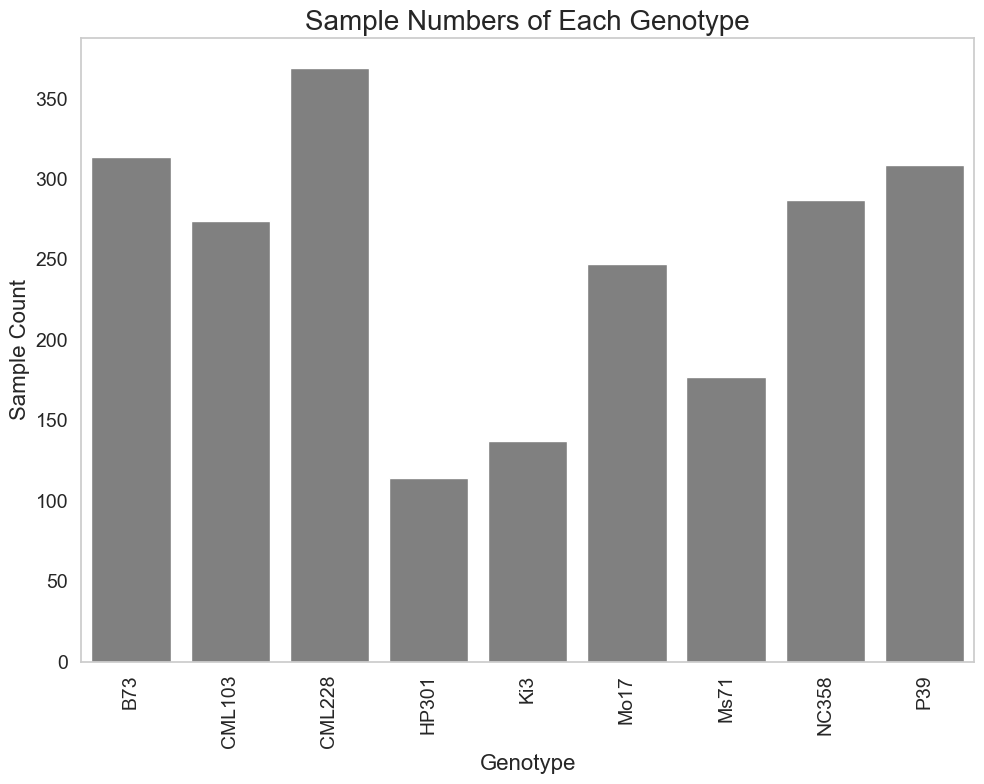

In [42]:
# Create a countplot with gray color for all genotypes
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Metadata_genotype.x', data=morph, color='gray')

# Set the title and labels
plt.title('Sample Numbers of Each Genotype', fontsize=20)
plt.xlabel('Genotype', fontsize=16)
plt.ylabel('Sample Count', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)

plt.tight_layout()
plt.show()

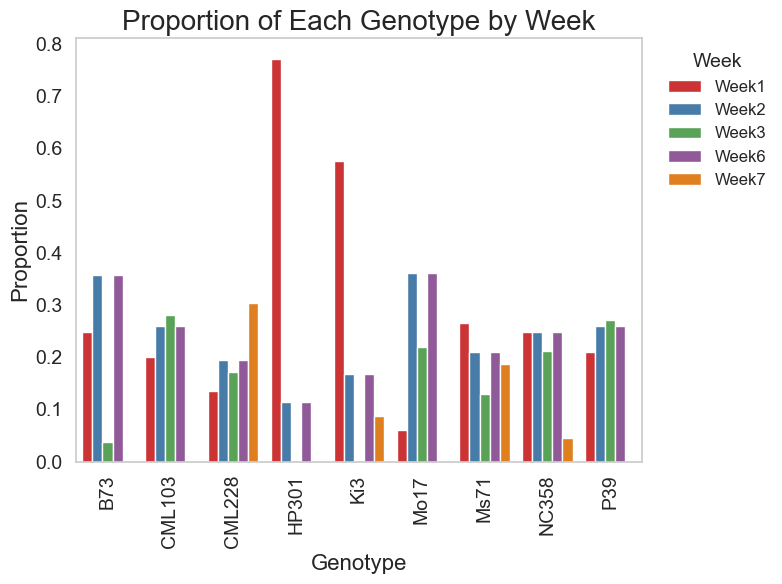

In [186]:
# Compute sample numbers of each genotype grouped by Metadata_week.x and Metadata_genotype.x
sample_counts = morph.groupby(['Metadata_week.x', 'Metadata_genotype.x']).size().reset_index(name='Sample Count')

# Compute the proportion of each genotype within each week
sample_counts['Proportion'] = sample_counts.groupby('Metadata_genotype.x')['Sample Count'].transform(lambda x: x / x.sum())

# Create a countplot
plt.figure(figsize=(8, 6))
sns.barplot(y='Proportion', x='Metadata_genotype.x', hue='Metadata_week.x', data=sample_counts, palette='Set1')

plt.title('Proportion of Each Genotype by Week', fontsize=20)
plt.xlabel('Genotype', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(title='Week', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()

In [187]:
print(y_true)

     Metadata_genotype.x
56                   B73
494                  Ki3
1676              CML228
218                HP301
744               CML228
...                  ...
1911               NC358
2033                 P39
1132              CML103
700               CML103
1228              CML228

[446 rows x 1 columns]


    Metadata_genotype.x  index2
0                   B73      56
1                   Ki3     494
2                CML228    1676
3                 HP301     218
4                CML228     744
..                  ...     ...
441               NC358    1911
442                 P39    2033
443              CML103    1132
444              CML103     700
445              CML228    1228

[446 rows x 2 columns]
    Metadata_genotype.x_x  index2  index pred_genotype.x  Unnamed: 0  \
0                   HP301     218      3             P39         218   
1                     P39     543      8           HP301         543   
2                    Mo17    1284      9            Ms71        1284   
3                     Ki3    2178     15          CML103        2178   
4                     P39     423     18          CML103         423   
..                    ...     ...    ...             ...         ...   
134                  Mo17    1304    433             P39        1304   
135             

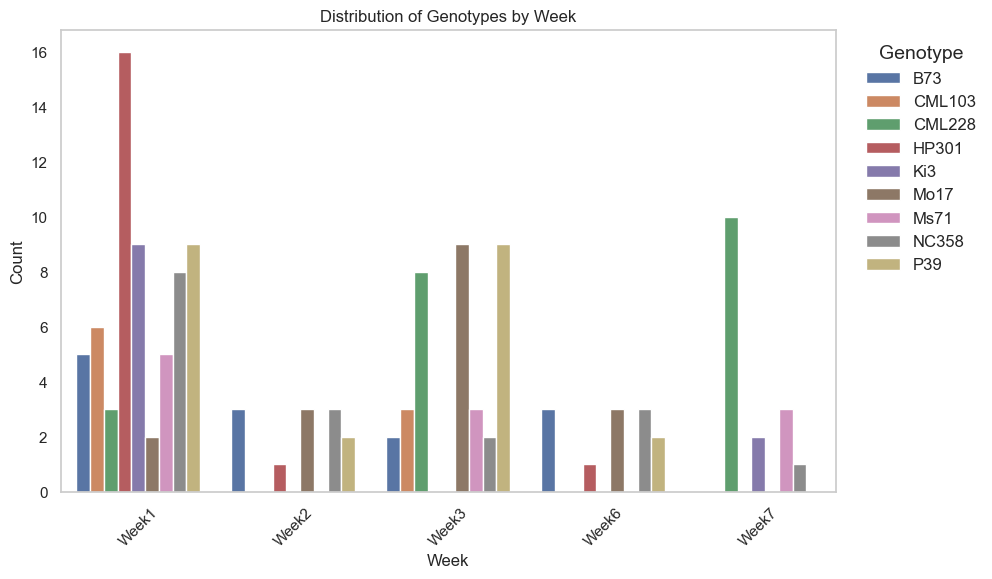

In [188]:
### Detect if the wrong lable for certain genotype is from the same image or not

df = pd.DataFrame(y_pred, columns=['pred_genotype.x'])
df['index'] = df.index

y_true['index2'] = y_true.index
y_true.reset_index(drop=True, inplace=True)

print(y_true)

y_true['index'] = y_true.index
merged_df = pd.merge(y_true, df, on='index')

# Filter rows where 'Metadata_genotype.x' is not equal to 'pred_genotype.x'
filtered_df = merged_df[merged_df['Metadata_genotype.x'] != merged_df['pred_genotype.x']]

# Merge the base DataFrame with the week DataFrame based on the index
merged_df2 = pd.merge(filtered_df, morph, left_on = 'index2', right_on='Unnamed: 0')

merged_df2 = merged_df2.iloc[:, :7]


print(merged_df2)
# Count occurrences of each genotype by week
genotype_counts = merged_df2.groupby(['Metadata_week.x', 'Metadata_genotype.x_x']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genotype_counts, x='Metadata_week.x', y='Count', hue='Metadata_genotype.x_x')
plt.grid(False)
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Distribution of Genotypes by Week')
plt.legend(title='Genotype', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
plt.xticks(rotation=45)
plt.show()

      Metric  All_feature       SCO       GCO
0  Precision     0.697872  0.575083  0.663166
1     Recall     0.688341  0.567265  0.647982
2   F1 Score     0.685820  0.564795  0.641036
3   Accuracy     0.688341  0.567265  0.647982


<Figure size 1000x600 with 0 Axes>

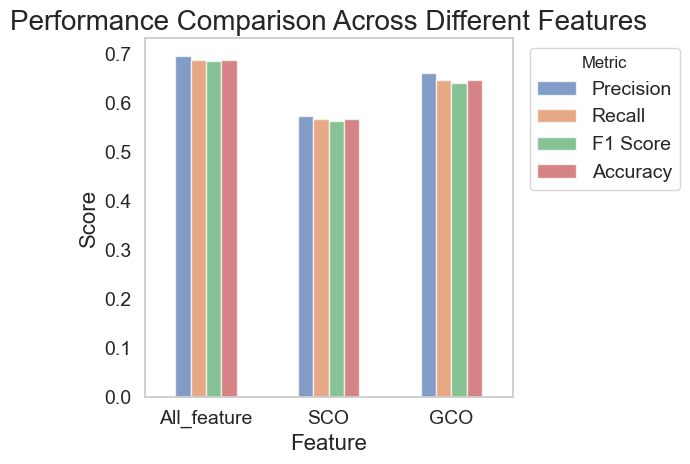

In [204]:
### use the same pipeline, but use individual GCO and SCO features and comparing the performance

# Define the data
data = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'All_feature': [0.6978723168837083, 0.6883408071748879, 0.6858196011071382, 0.6883408071748879],
    'SCO': [0.5750834622950078, 0.5672645739910314, 0.5647948042819123, 0.5672645739910314],
    'GCO': [0.6631655033594059, 0.647982062780269, 0.6410359584266648, 0.647982062780269]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plotting
plt.figure(figsize=(10, 6))

df_transposed = df.set_index('Metric').transpose()
df_transposed.plot(kind='bar', alpha=0.7)
plt.title('Performance Comparison Across Different Features', fontsize=20)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Metric', fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(False)

plt.tight_layout()
plt.show()

/Users/houlinyu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


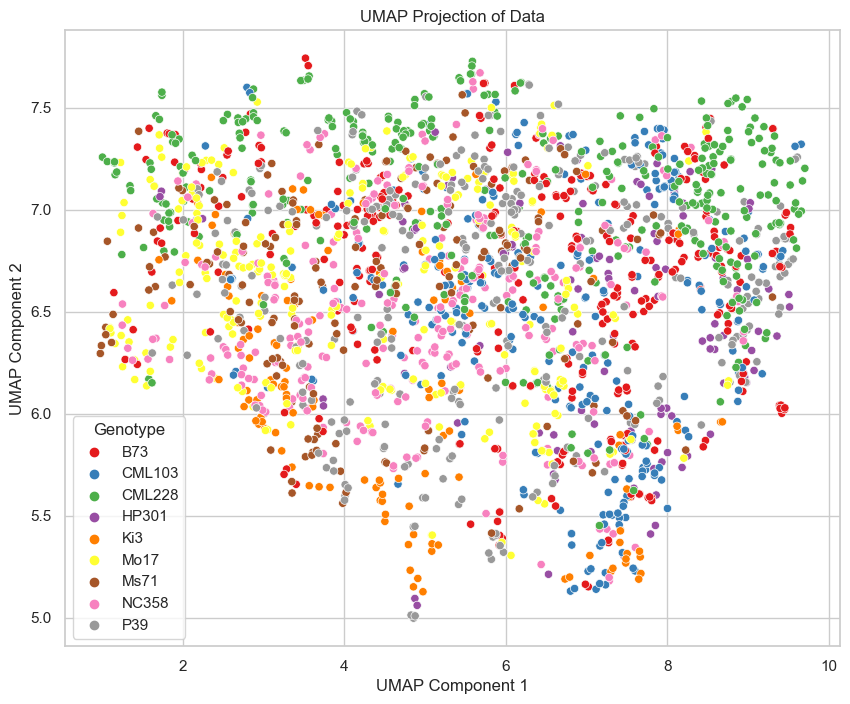

In [41]:
## !pip install umap-learn
import umap
df = pd.read_csv("Oscar_scaled_morph2.csv")
features = df.filter(regex='^(GCO|avg_)')
genotype = df['Metadata_genotype.x']

# Initialize UMAP with desired parameters
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.4, n_components=50, random_state=42)

# Fit UMAP to your data and transform it to the lower-dimensional space
umap_result = umap_model.fit_transform(features)

# Plot the UMAP projection, color-coded by genotype
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=genotype, palette='Set1', legend='full')
plt.title('UMAP Projection of Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Genotype')
plt.show()


/var/folders/gt/w451x6dd2xs29hm6r8jx9bph0000gn/T/ipykernel_74112/1193287815.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(genotypes).mean()
/var/folders/gt/w451x6dd2xs29hm6r8jx9bph0000gn/T/ipykernel_74112/1193287815.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = hierarchy.linkage(distance_matrix, method='complete')


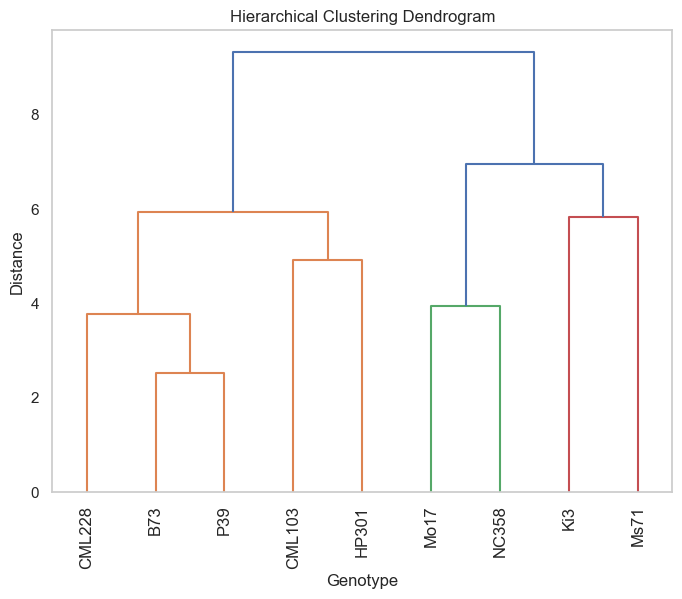

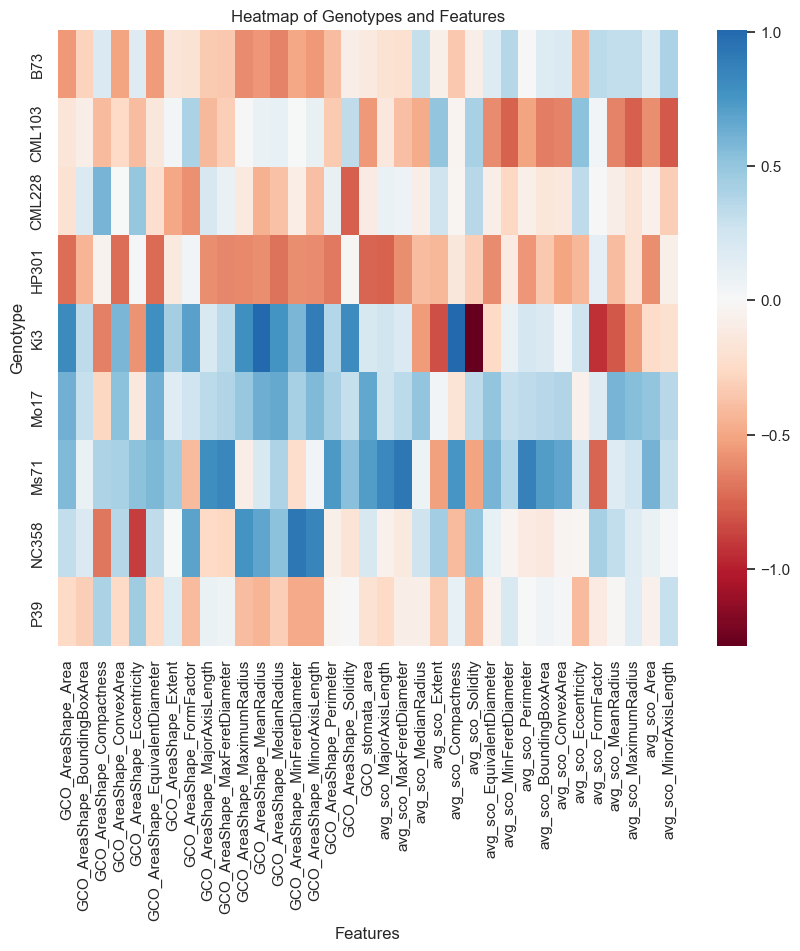

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster import hierarchy
# Load the data
data = pd.read_csv("Oscar_scaled_morph2.csv")

genotypes = df['Metadata_genotype.x']

# Aggregate data for each genotype by calculating the mean
aggregated_data = data.groupby(genotypes).mean()

# Select relevant features for building the phylogenetic tree
selected_features = aggregated_data.filter(regex='^(GCO|avg_)')
# bset the data frame to include only the selected features
data = selected_features

# Calculate the distance matrix using Euclidean distance
distance_matrix = distance.squareform(distance.pdist(data, metric='euclidean'))

# Perform hierarchical clustering using complete linkage
clustering = hierarchy.linkage(distance_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(8, 6))
plt.grid(False)
dendrogram = hierarchy.dendrogram(clustering, labels=aggregated_data.index, orientation='top')

# Add title and labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Genotype')
plt.ylabel('Distance')

plt.xticks(rotation=90)
plt.show()

# Create a heatmap with a diverging colormap
plt.figure(figsize=(10, 8))
sns.heatmap(data, cmap='RdBu', center=0, cbar=True)  # Use 'RdBu' colormap for red to blue transition
plt.title('Heatmap of Genotypes and Features')
plt.xlabel('Features')
plt.ylabel('Genotype')
plt.show()